# Multi-GPU Training Example

Train a convolutional neural network on multiple GPU with TensorFlow.

## Training with multiple GPU cards

In this example, we are using data parallelism to split the training accross multiple GPUs. Each GPU has a full replica of the neural network model, and the weights (i.e. variables) are updated synchronously by waiting that each GPU process its batch of data.

First, each GPU process a distinct batch of data and compute the corresponding gradients, then, all gradients are accumulated in the CPU and averaged. The model weights are finally updated with the gradients averaged, and the new model weights are sent back to each GPU, to repeat the training process.

<img src="https://www.tensorflow.org/images/Parallelism.png" alt="Parallelism" style="width: 400px;"/>

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flatten and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
num_gpus = 2
num_steps = 200
learning_rate = 0.001
batch_size = 1024
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


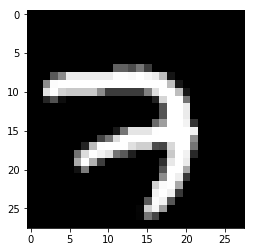

In [2]:
first_image=mnist.train.images[0]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [3]:
# Build a convolutional neural network
def conv_net(x, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 64 filters and a kernel size of 5
        x = tf.layers.conv2d(x, 64, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        x = tf.layers.max_pooling2d(x, 2, 2)

        # Convolution Layer with 256 filters and a kernel size of 3
        x = tf.layers.conv2d(x, 256, 3, activation=tf.nn.relu)
        # Convolution Layer with 512 filters and a kernel size of 3
        x = tf.layers.conv2d(x, 512, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        x = tf.layers.max_pooling2d(x, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        x = tf.contrib.layers.flatten(x)

        # Fully connected layer (in contrib folder for now)
        x = tf.layers.dense(x, 2048)
        # Apply Dropout (if is_training is False, dropout is not applied)
        x = tf.layers.dropout(x, rate=dropout, training=is_training)

        # Fully connected layer (in contrib folder for now)
        x = tf.layers.dense(x, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        x = tf.layers.dropout(x, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(x, n_classes)
        # Because 'softmax_cross_entropy_with_logits' loss already apply
        # softmax, we only apply softmax to testing network
        out = tf.nn.softmax(out) if not is_training else out

    return out

In [4]:
# Build the function to average the gradients
def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads, 0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

In [5]:
# By default, all variables will be placed on '/gpu:0'
# So we need a custom device function, to assign all variables to '/cpu:0'
# Note: If GPUs are peered, '/gpu:0' can be a faster option
PS_OPS = ['Variable', 'VariableV2', 'AutoReloadVariable']

def assign_to_device(device, ps_device='/cpu:0'):
    def _assign(op):
        node_def = op if isinstance(op, tf.NodeDef) else op.node_def
        if node_def.op in PS_OPS:
            return "/" + ps_device
        else:
            return device

    return _assign

In [6]:
# Place all ops on CPU by default
start = time.time()

with tf.device('/cpu:0'):
    tower_grads = []
    reuse_vars = False

    # tf Graph input
    X = tf.placeholder(tf.float32, [None, num_input])
    Y = tf.placeholder(tf.float32, [None, num_classes])

    # Loop over all GPUs and construct their own computation graph
    for i in range(num_gpus):
        with tf.device(assign_to_device('/gpu:{}'.format(i), ps_device='/cpu:0')):

            # Split data between GPUs
            _x = X[i * batch_size: (i+1) * batch_size]
            _y = Y[i * batch_size: (i+1) * batch_size]

            # Because Dropout have different behavior at training and prediction time, we
            # need to create 2 distinct computation graphs that share the same weights.

            # Create a graph for training
            logits_train = conv_net(_x, num_classes, dropout,
                                    reuse=reuse_vars, is_training=True)
            # Create another graph for testing that reuse the same weights
            logits_test = conv_net(_x, num_classes, dropout,
                                   reuse=True, is_training=False)

            # Define loss and optimizer (with train logits, for dropout to take effect)
            loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                logits=logits_train, labels=_y))
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            grads = optimizer.compute_gradients(loss_op)

            # Only first GPU compute accuracy
            if i == 0:
                # Evaluate model (with test logits, for dropout to be disabled)
                correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.argmax(_y, 1))
                accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

            reuse_vars = True
            tower_grads.append(grads)

    tower_grads = average_gradients(tower_grads)
    train_op = optimizer.apply_gradients(tower_grads)

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)
        step = 1
        # Keep training until reach max iterations
        for step in range(1, num_steps + 1):
            # Get a batch for each GPU
            batch_x, batch_y = mnist.train.next_batch(batch_size * num_gpus)
            # Run optimization op (backprop)
            ts = time.time()
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            te = time.time() - ts
            if step % display_step == 0 or step == 1:
                # Calculate batch loss and accuracy
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                     Y: batch_y})
                print("Step " + str(step) + ": Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc) + ", %i Examples/sec" % int(len(batch_x)/te))
            step += 1
        print("Optimization Finished!")

        # Calculate accuracy for 1000 mnist test images
        print("Testing Accuracy:", \
            np.mean([sess.run(accuracy, feed_dict={X: mnist.test.images[i:i+batch_size],
            Y: mnist.test.labels[i:i+batch_size]}) for i in range(0, len(mnist.test.images), batch_size)]))
        
end = time.time()
print("")
print("Training time = %d seconds" %(end - start))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Step 1: Minibatch Loss= 2.4931, Training Accuracy= 0.106, 198 Examples/sec
Step 10: Minibatch Loss= 0.5288, Training Accuracy= 0.881, 6730 Examples/sec
Step 20: Minibatch Loss= 0.2860, Training Accuracy= 0.937, 6655 Examples/sec
Step 30: Minibatch Loss= 0.1506, Training Accuracy= 0.955, 6706 Examples/sec
Step 40: Minibatch Loss= 0.1015, Training Accuracy= 0.979, 6673 Examples/sec
Step 50: Minibatch Loss= 0.0972, Training Accuracy= 0.991, 6690 Examples/sec
Step 60: Minibatch Loss= 0.0910, Training Accuracy= 0.983, 6697 Examples/sec
Step 70: Minibatch Loss= 0.0592, Training Accuracy= 0.987, 6667 Examples/sec
Step 80: Minibatch Loss= 0.0449, Training Accuracy= 0.987, 6684 Examples/sec
Step 90: Minibatch Loss= 0.0391, Training Accuracy= 0.990, 6667 Examples/sec
Step 100: Minibatch Loss= 0.0442, Training 